In [1]:
# Build session:
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import SparkSession

from pyspark.sql import Window
from pyspark.sql.functions import row_number, desc, col

from pyspark.sql.functions import explode
import sys
from gentropy.common.session import Session
from pyspark.sql import functions as f

from pyspark import SparkConf
from pyspark.sql import SparkSession
app_name = "example_app"
CREDENTIALS = "/Users/xg1/.config/gcloud/service_account_credentials.json" # Change as needed


GCS_CONNECTOR_CONF = {
    "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
    "spark.jars": "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar",
    "spark.hadoop.google.cloud.auth.service.account.enable": "true",
    "spark.hadoop.google.cloud.auth.service.account.json.keyfile": CREDENTIALS,
}

extended_spark_conf = {
    "spark.driver.memory": "12g",
    "spark.kryoserializer.buffer.max": "500m",
    "spark.driver.maxResultSize": "3g",
}

combined_conf = {**GCS_CONNECTOR_CONF, **extended_spark_conf}
spark_config = SparkConf().setAll(combined_conf.items())
session = SparkSession.builder.config(conf=spark_config).appName(app_name).getOrCreate()

Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/11/06 10:11:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/06 10:11:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
EGL_GSP=session.read.parquet("/Users/xg1/Downloads/EGL_GSP_2410_freeze6.parquet")
feature_matrix=session.read.parquet("gs://ot_orchestration/releases/24.10_freeze6/locus_to_gene_feature_matrix")

EGL_studylocus=EGL_GSP.withColumnRenamed("geneId", "positive_geneId").select("studyLocusId", "positive_geneId").distinct().join(feature_matrix, on="studyLocusId", how="inner").persist()
#EGL_studylocus.count()

24/11/06 10:11:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
GSN=EGL_studylocus.filter(f.col("geneId") != f.col("positive_geneId"))
#GSN.count()

In [5]:
# Use functions from l2g.py to generate GSN:

from gentropy.common.spark_helpers import get_record_with_maximum_value

gene_interactions=session.read.parquet("gs://genetics_etl_python_playground/static_assets/interaction/")
gene_interactions_formatted=get_record_with_maximum_value(
            gene_interactions,
            ["targetA", "targetB"],
            "scoring",
        ).selectExpr(
            "targetA as geneIdA",
            "targetB as geneIdB",
            "scoring as score",
        )

GSN_with_interactions = GSN.join(
    gene_interactions_formatted,
    (GSN.geneId == gene_interactions_formatted.geneIdA) & (GSN.positive_geneId == gene_interactions_formatted.geneIdB),
    how="left"
)


filtered_GSN = GSN_with_interactions.filter((f.col("score").isNull()) | (f.col("score") <= 0.7))

filtered_GSN = filtered_GSN.drop("geneIdA", "geneIdB", "score")

filtered_GSN.write.mode("overwrite").parquet("/Users/xg1/Downloads/feature_matrix_gsn_2410_freeze6.parquet")

In [6]:
# Checkpoint for downsampling GSNs:

filtered_GSN=session.read.parquet("/Users/xg1/Downloads/feature_matrix_gsn.parquet")
num_rows = filtered_GSN.count()
print(f"Number of rows in filtered_GSN: {num_rows}")

distinct_studyLocus = filtered_GSN.select("studyLocusId").distinct().count()
print(f"Number of distinct studyLocusId: {distinct_studyLocus}")

distinct_studyLocus_gene_pairs = filtered_GSN.select("studyLocusId", "geneId").distinct().count()
print(f"Number of distinct studyLocusId to geneId pairs: {distinct_studyLocus_gene_pairs}")

distinct_studyLocus_gene_pairs = filtered_GSN.select("studyLocusId", "positive_geneId").distinct().count()
print(f"Number of distinct studyLocusId to geneId pairs: {distinct_studyLocus_gene_pairs}")

Number of rows in filtered_GSN: 41795


Number of distinct studyLocusId: 537


Number of distinct studyLocusId to geneId pairs: 33818


Number of distinct studyLocusId to geneId pairs: 582


In [6]:
# Define the prioritised features
Prioritised_features = ["eQtlColocClppMaximum", "eQtlColocH4Maximum", "pQtlColocClppMaximum", 
                        "pQtlColocH4Maximum", "sQtlColocClppMaximum", "sQtlColocH4Maximum", 
                        "vepMaximum", "vepMean"]

null_or_zero_count_per_row = sum(f.when((f.col(c).isNull()) | (f.col(c) == 0), 0).otherwise(1) for c in Prioritised_features)
GS_fm_with_count = filtered_GSN.withColumn("null_or_zero_count", null_or_zero_count_per_row)

window_spec = Window.partitionBy("studyLocusId").orderBy(f.col("null_or_zero_count").desc())
ranked_df = GS_fm_with_count.withColumn("row_number", f.row_number().over(window_spec))
filtered_df = ranked_df.filter(f.col("row_number") <= 3).drop("row_number")

gs_source_counts = filtered_df.groupBy("null_or_zero_count").count()
gs_source_counts.orderBy(f.col("null_or_zero_count")).show(50)

+------------------+-----+
|null_or_zero_count|count|
+------------------+-----+
|                 0|  486|
|                 1|   97|
|                 2|  433|
|                 3|   56|
|                 4|  238|
|                 5|    4|
|                 6|  136|
|                 8|    8|
+------------------+-----+



In [10]:
filtered_df.filter(f.col("null_or_zero_count") > 0).count()

972

In [8]:
filtered_df.filter(f.col("null_or_zero_count") > 0).write.mode("overwrite").parquet("/Users/xg1/Downloads/feature_matrix_gsn_downsampled_2410_freeze6.parquet")

In [ ]:
exclude_columns = ["positive_geneId", "geneId", "studyLocusId", "distanceFootprintMean", "distanceFootprintMeanNeighbourhood", "distanceSentinelFootprint", "distanceSentinelFootprintNeighbourhood", "distanceSentinelTss", "distanceSentinelTssNeighbourhood", "distanceTssMean", "distanceTssMeanNeighbourhood"]

columns_to_check = [col for col in filtered_GSN.columns if col not in exclude_columns]

non_zero_count_per_row = sum(f.when((f.col(c) != 0) & (f.col(c).isNotNull()), 1).otherwise(0) for c in columns_to_check)

filtered_GSN_with_count = filtered_GSN.withColumn("non_zero_non_null_count", non_zero_count_per_row)

aggregated_df = filtered_GSN_with_count.groupBy("studyLocusId").agg(f.sum("non_zero_non_null_count").alias("total_non_zero_non_null_count"))

filtered_GSN_with_count.show()

In [ ]:
gs_source_counts = filtered_GSN_with_count.groupBy("non_zero_non_null_count").count()

gs_source_counts.orderBy(f.col("non_zero_non_null_count")).show(50)

In [ ]:
from pyspark.sql import Window

window_spec = Window.partitionBy("studyLocusId").orderBy(f.col("non_zero_non_null_count").desc())
ranked_df = filtered_GSN_with_count.withColumn("row_number", f.row_number().over(window_spec))
filtered_df = ranked_df.filter(f.col("row_number") <= 5).drop("row_number")

filtered_df.show()

In [24]:
gs_source_counts = filtered_df.groupBy("non_zero_non_null_count").count()
num_study_locus_used=filtered_df.select("studyLocusId").distinct().count()

print(f"summary of non-missing features across {num_study_locus_used} studyLocusIds")
gs_source_counts.orderBy(f.col("non_zero_non_null_count")).show(50)

summary of non-missing features across 829 studyLocusIds


+-----------------------+-----+
|non_zero_non_null_count|count|
+-----------------------+-----+
|                      0|   20|
|                      3| 2007|
|                      4|  165|
|                      5|  754|
|                      6|   58|
|                      7|  449|
|                      8|   34|
|                      9|  416|
|                     10|    5|
|                     11|   94|
|                     13|  136|
|                     15|    2|
|                     17|    5|
+-----------------------+-----+



In [28]:
filtered_df.filter(f.col("non_zero_non_null_count") > 6).write.parquet("/Users/xg1/Downloads/feature_matrix_gsn_downsampled.parquet")

In [11]:
Downsampled_GSN=session.read.parquet("/Users/xg1/Downloads/feature_matrix_gsn_downsampled_2410_freeze6.parquet").withColumn("Goldstandard_positive", f.lit(0)).drop("positive_geneId")

GSP=session.read.parquet("/Users/xg1/Downloads/feature_matrix_gsp_2410_freeze6.parquet").withColumn("Goldstandard_positive", f.lit(1)).drop("traitFromSourceMappedId", "studyId", "traitFromSource", "GS_source", "diseaseFromSource")

training_set=Downsampled_GSN.unionByName(GSP)
training_set.count()

1521

In [16]:
training_set.show()

+--------------------+---------------+---------------------+---------------------+----------------------------------+-------------------------+--------------------------------------+-------------------+--------------------------------+---------------+----------------------------+--------------------+---------------------------------+------------------+-------------------------------+--------------+---------------+--------------------+---------------------------------+------------------+-------------------------------+---------------------+--------------------+---------------------------------+------------------+-------------------------------+----------+-----------------------+------------+--------------------+------------------+---------------------+
|        studyLocusId|         geneId|credibleSetConfidence|distanceFootprintMean|distanceFootprintMeanNeighbourhood|distanceSentinelFootprint|distanceSentinelFootprintNeighbourhood|distanceSentinelTss|distanceSentinelTssNeighbourhood|dis

In [28]:
training_set.write.mode("overwrite").parquet("/Users/xg1/Downloads/EGL_training_set_2410_freeze6.parquet")
training_set.write.mode("overwrite").parquet("gs://genetics-portal-dev-analysis/xg1/Chembl_l2g_goldstandards/EGL_training_set_2410_freeze6.parquet")

In [24]:
training_set.printSchema()

root
 |-- studyLocusId: string (nullable = true)
 |-- geneId: string (nullable = true)
 |-- credibleSetConfidence: float (nullable = true)
 |-- distanceFootprintMean: float (nullable = true)
 |-- distanceFootprintMeanNeighbourhood: float (nullable = true)
 |-- distanceSentinelFootprint: float (nullable = true)
 |-- distanceSentinelFootprintNeighbourhood: float (nullable = true)
 |-- distanceSentinelTss: float (nullable = true)
 |-- distanceSentinelTssNeighbourhood: float (nullable = true)
 |-- distanceTssMean: float (nullable = true)
 |-- distanceTssMeanNeighbourhood: float (nullable = true)
 |-- eQtlColocClppMaximum: float (nullable = true)
 |-- eQtlColocClppMaximumNeighbourhood: float (nullable = true)
 |-- eQtlColocH4Maximum: float (nullable = true)
 |-- eQtlColocH4MaximumNeighbourhood: float (nullable = true)
 |-- geneCount500kb: double (nullable = true)
 |-- isProteinCoding: float (nullable = true)
 |-- pQtlColocClppMaximum: float (nullable = true)
 |-- pQtlColocClppMaximumNeighbo

In [23]:
training_set_filled.show()

+--------------------+---------------+---------------------+---------------------+----------------------------------+-------------------------+--------------------------------------+-------------------+--------------------------------+---------------+----------------------------+--------------------+---------------------------------+------------------+-------------------------------+--------------+---------------+--------------------+---------------------------------+------------------+-------------------------------+---------------------+--------------------+---------------------------------+------------------+-------------------------------+----------+-----------------------+------------+--------------------+------------------+---------------------+
|        studyLocusId|         geneId|credibleSetConfidence|distanceFootprintMean|distanceFootprintMeanNeighbourhood|distanceSentinelFootprint|distanceSentinelFootprintNeighbourhood|distanceSentinelTss|distanceSentinelTssNeighbourhood|dis

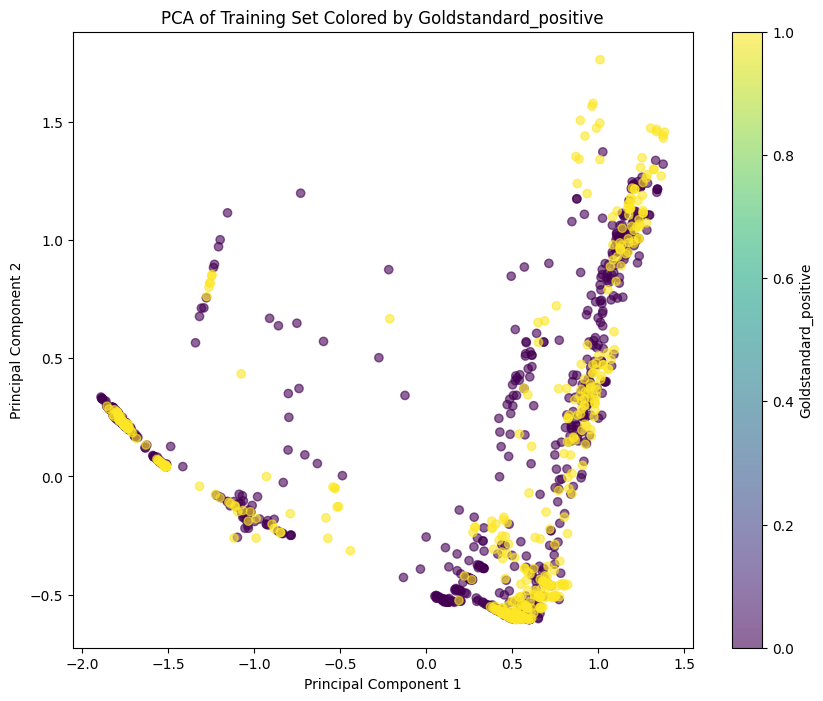

In [26]:
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

training_set_filled = training_set.fillna(0)
columns_for_pca = [
    col for col in training_set_filled.columns 
    if col not in ["studyLocusId", "geneId", "null_or_zero_count", "Goldstandard_positive", "geneCount500kb", "proteinGeneCount500kb"]
]


assembler = VectorAssembler(inputCols=columns_for_pca, outputCol="features", handleInvalid="keep")
df_with_features = assembler.transform(training_set_filled)

pandas_df = df_with_features.select("features", "Goldstandard_positive").toPandas()

features = pd.DataFrame(pandas_df["features"].apply(lambda x: x.toArray()).tolist(), columns=columns_for_pca)
labels = pandas_df["Goldstandard_positive"]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])

plt.figure(figsize=(10, 8))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=labels, cmap="viridis", alpha=0.6)
plt.colorbar(label="Goldstandard_positive")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Training Set Colored by Goldstandard_positive")
plt.show()

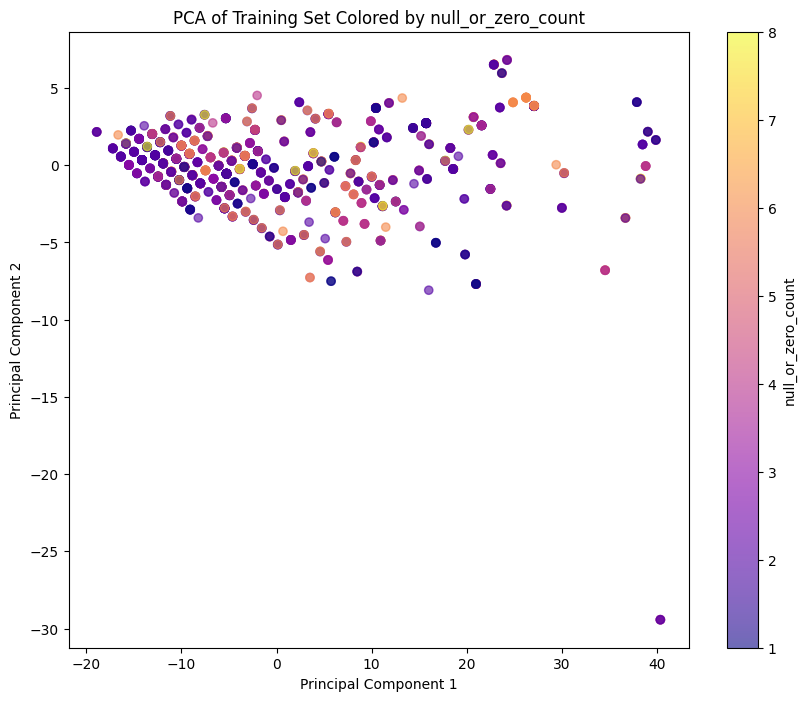

In [14]:
pandas_df = df_with_features.select("features", "Goldstandard_positive", "null_or_zero_count").toPandas()

features = pd.DataFrame(pandas_df["features"].apply(lambda x: x.toArray()).tolist(), columns=columns_for_pca)
labels = pandas_df["null_or_zero_count"]

plt.figure(figsize=(10, 8))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=labels, cmap="plasma", alpha=0.6)
plt.colorbar(label="null_or_zero_count")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Training Set Colored by null_or_zero_count")
plt.show()

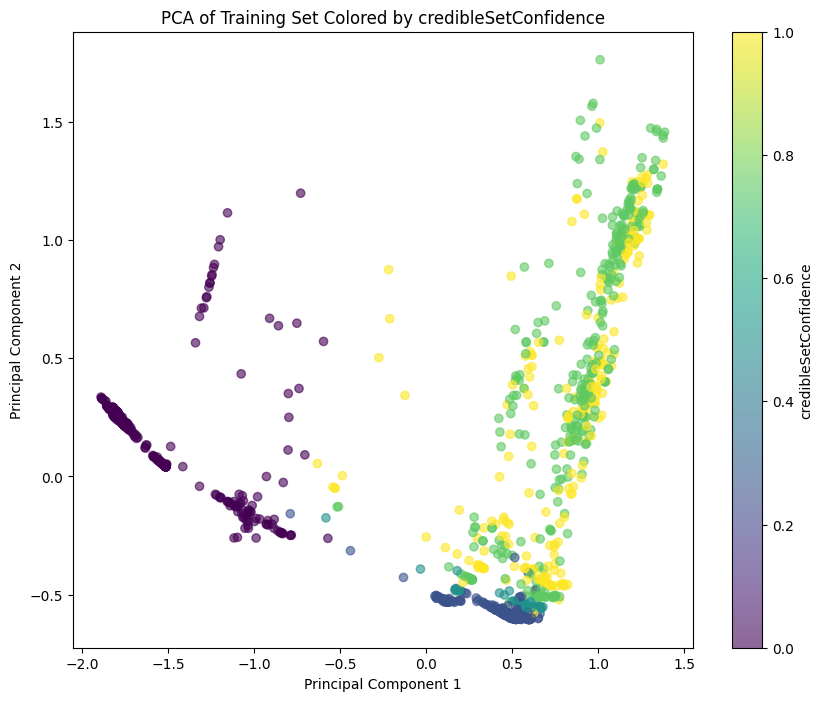

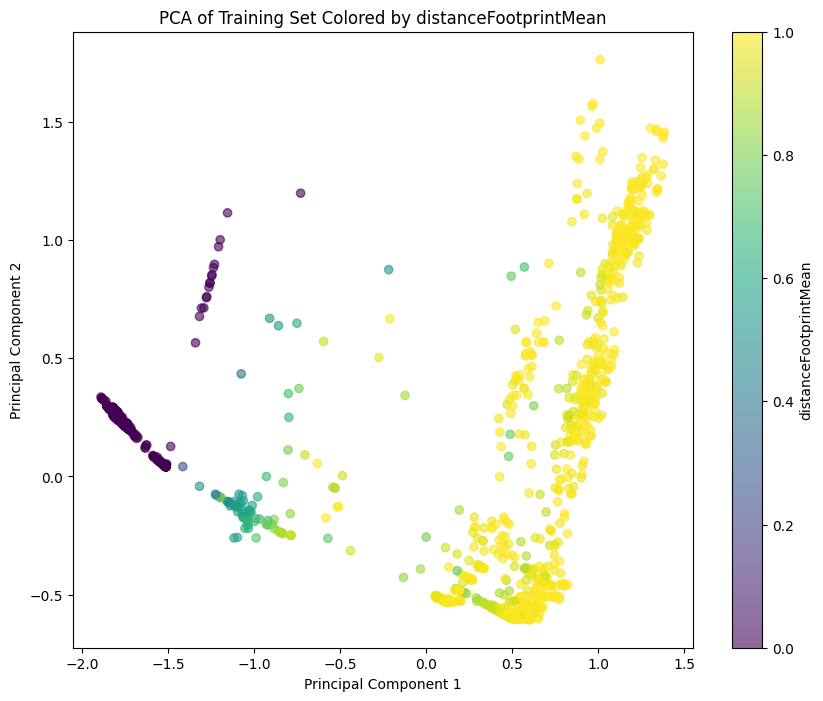

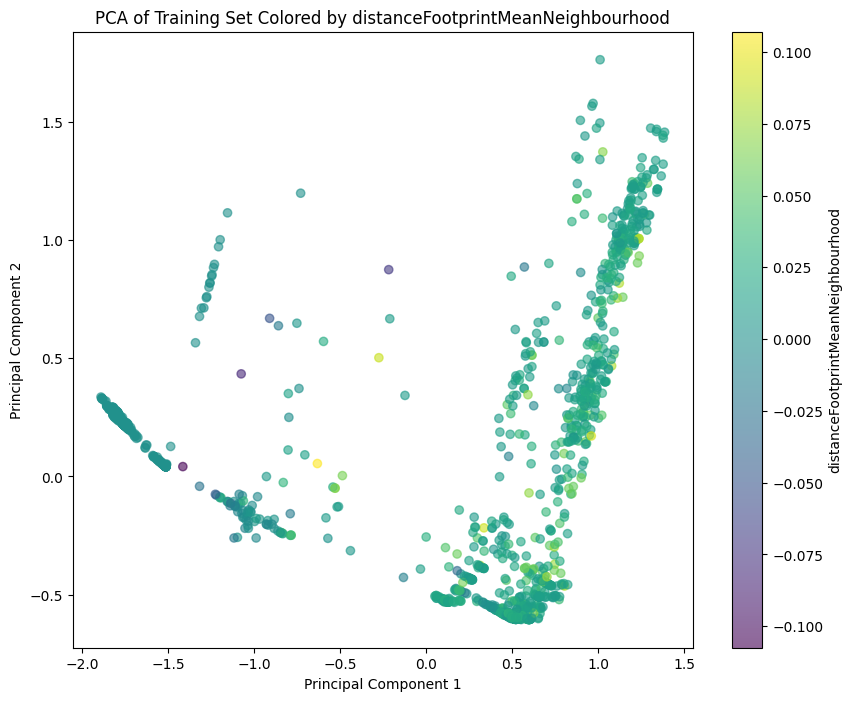

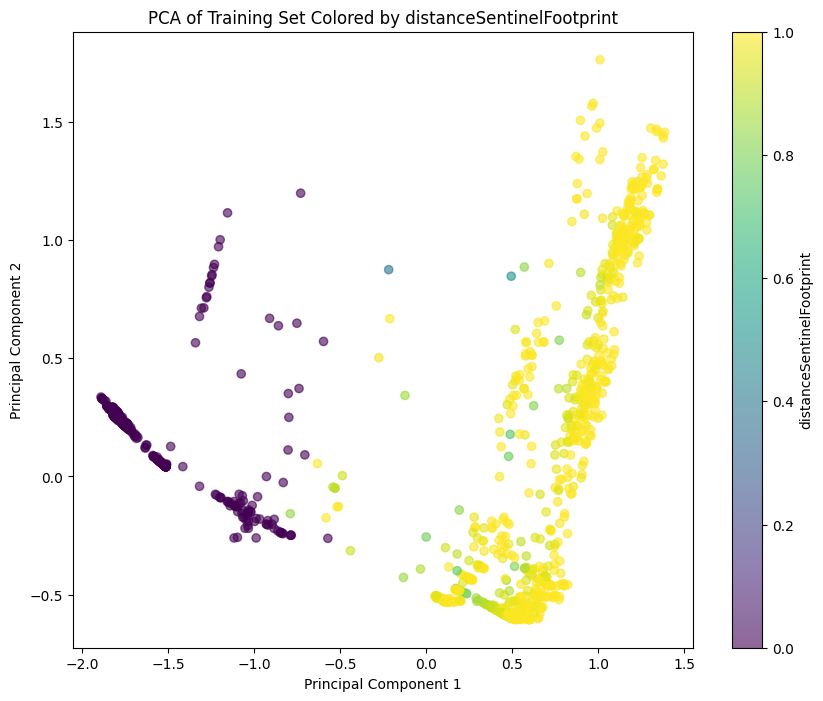

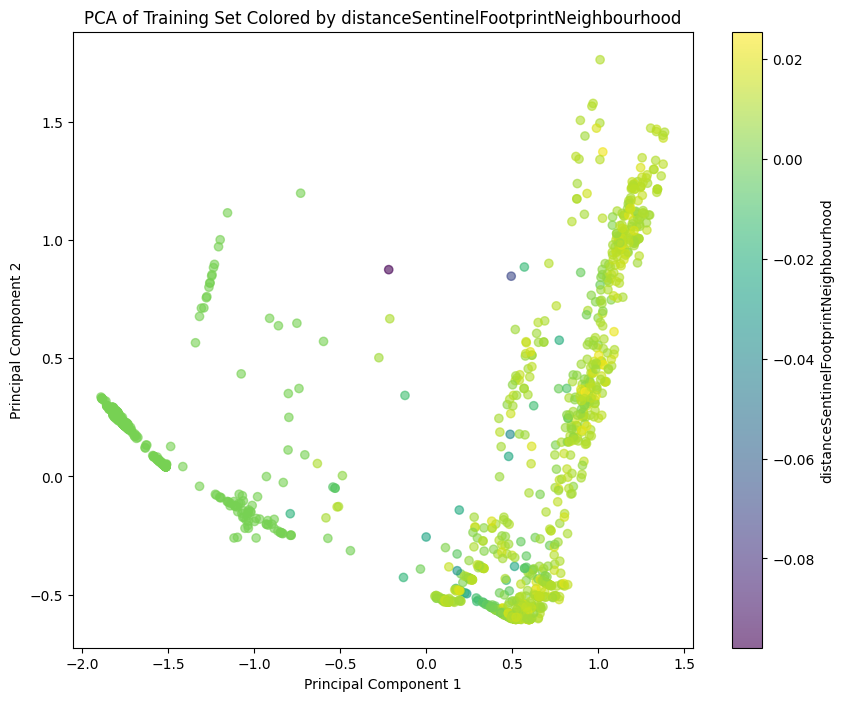

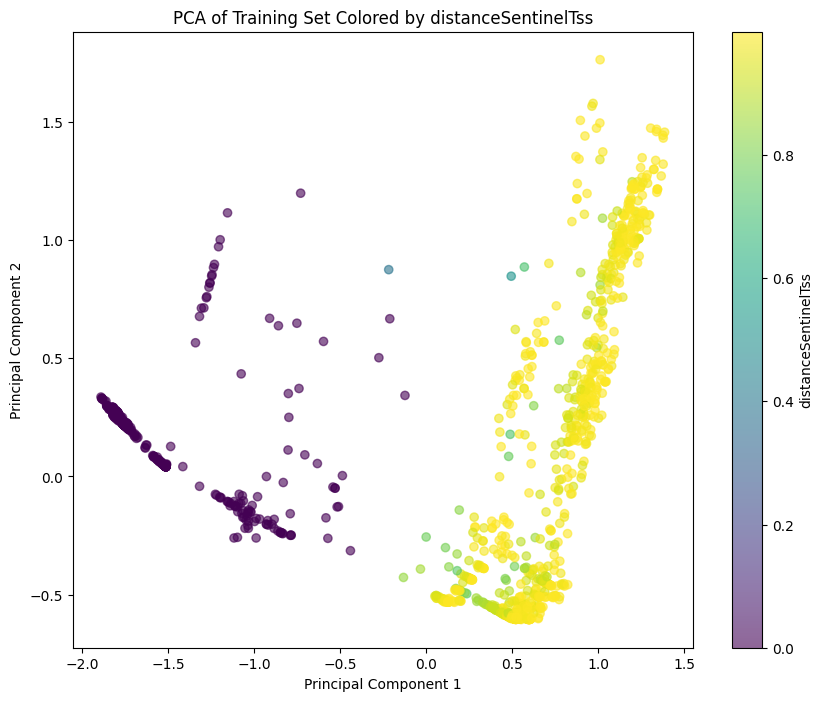

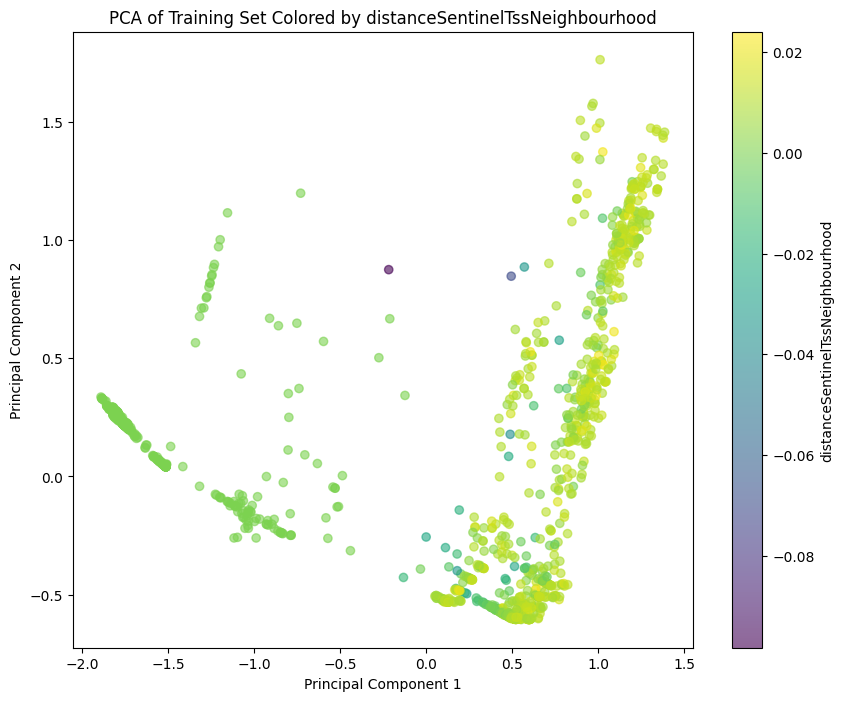

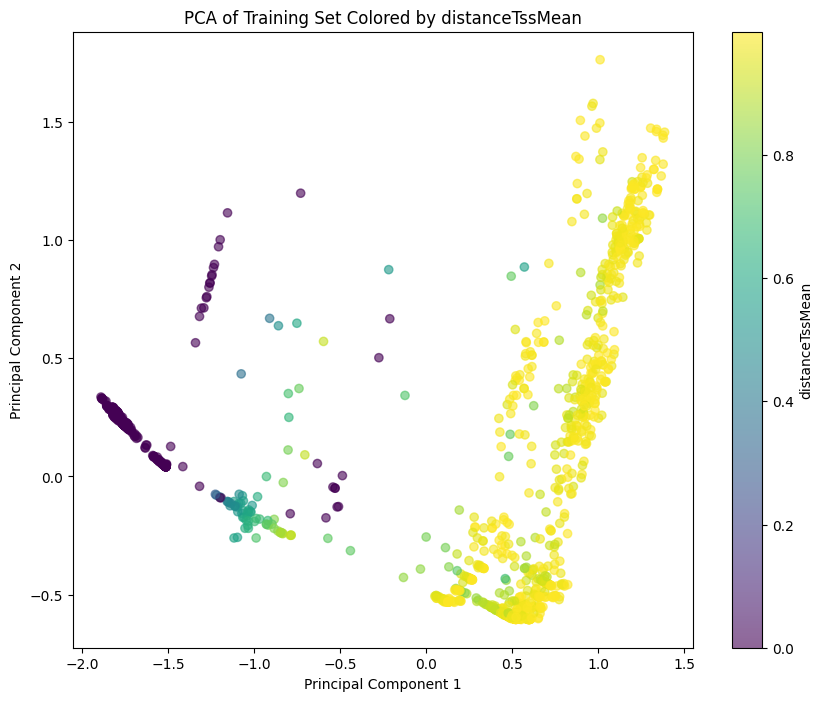

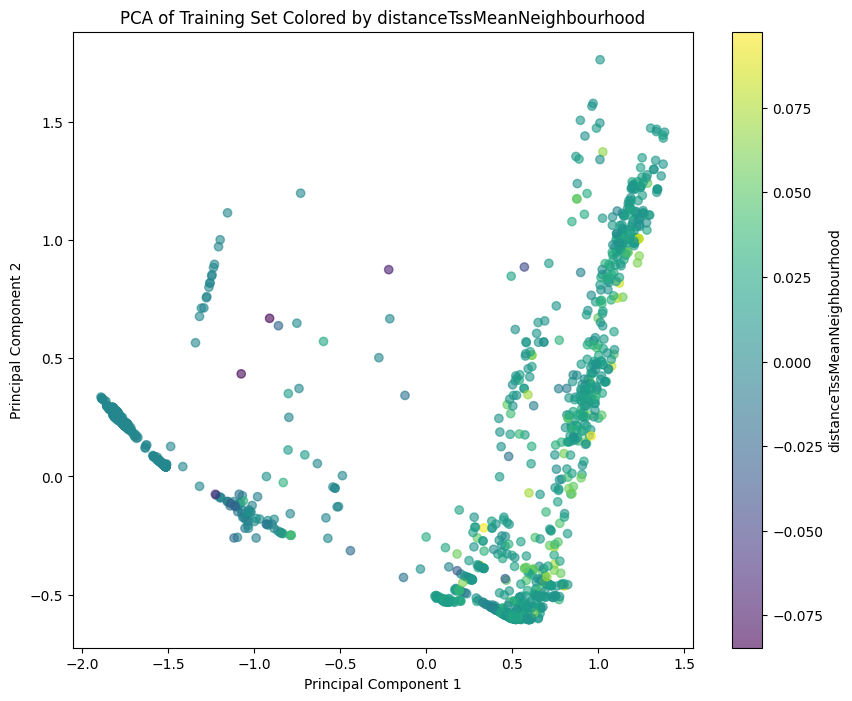

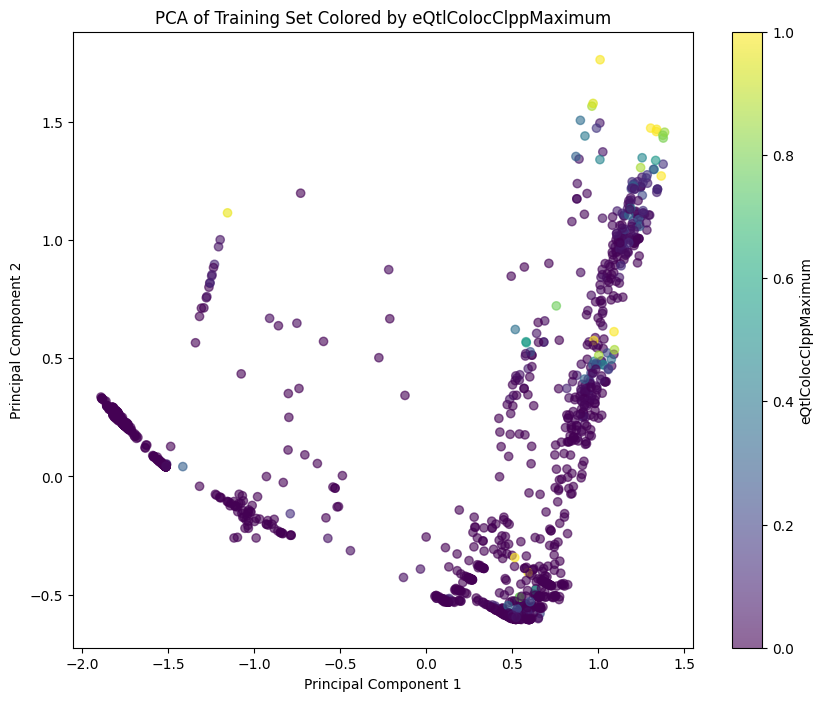

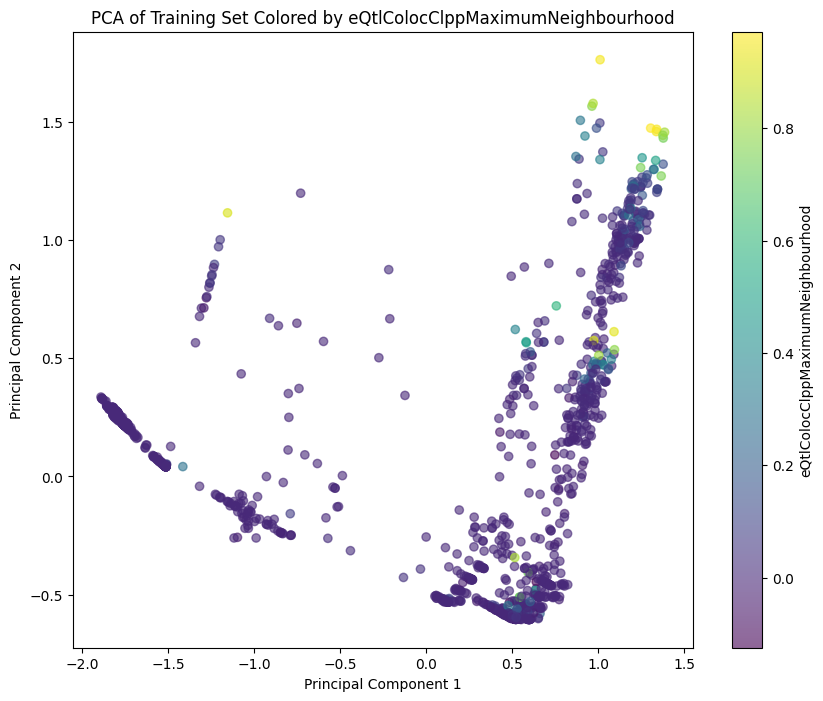

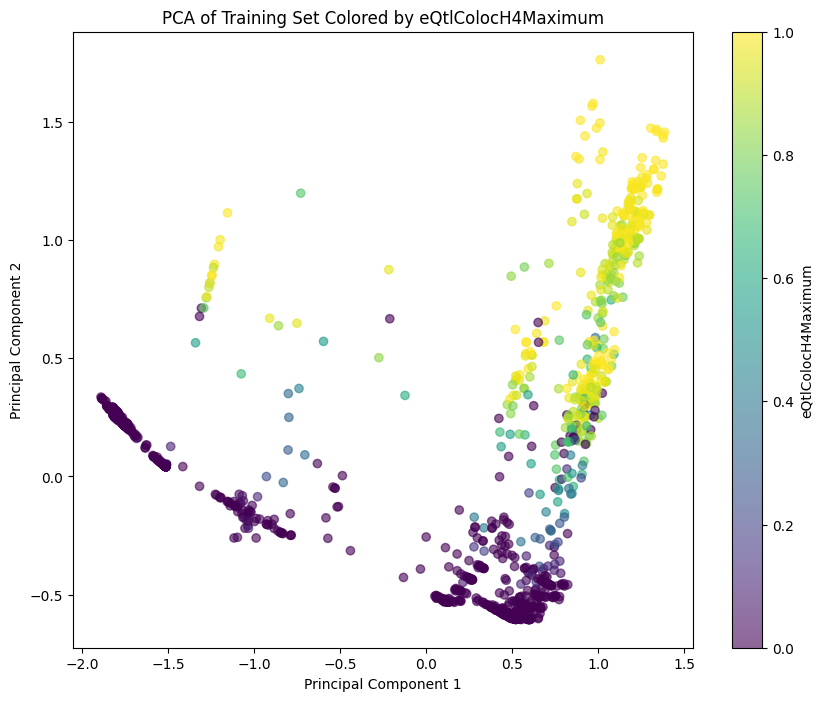

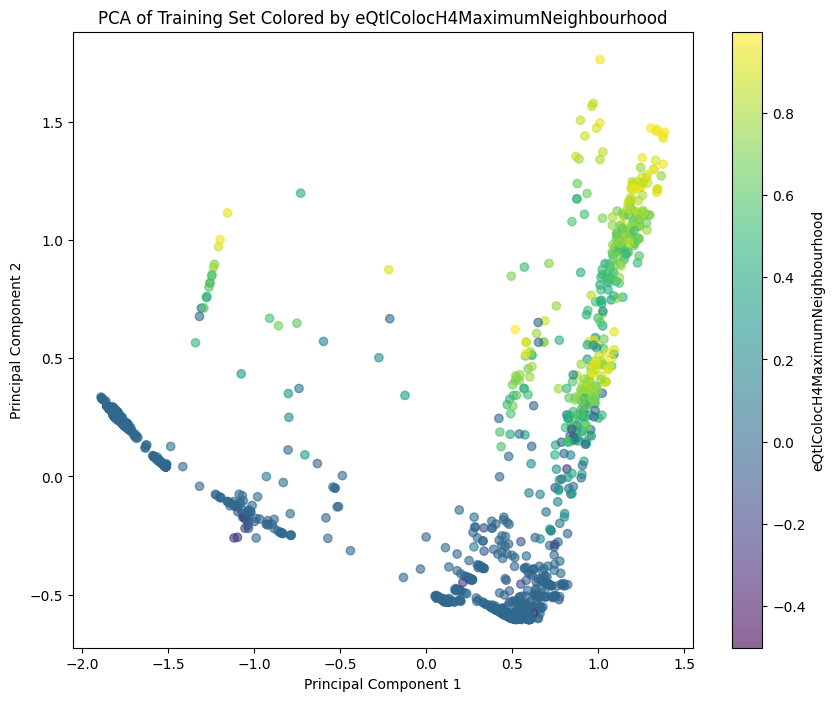

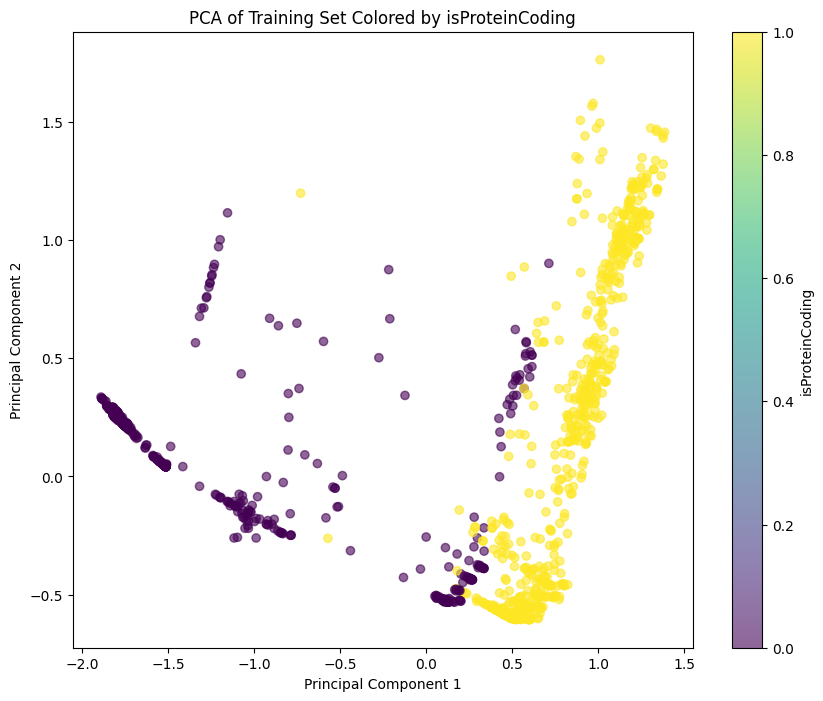

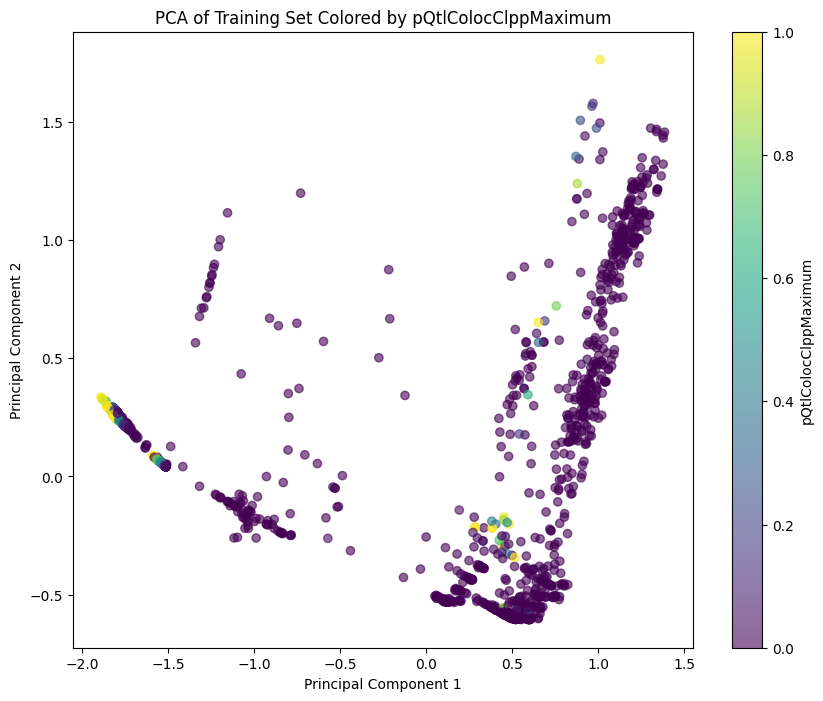

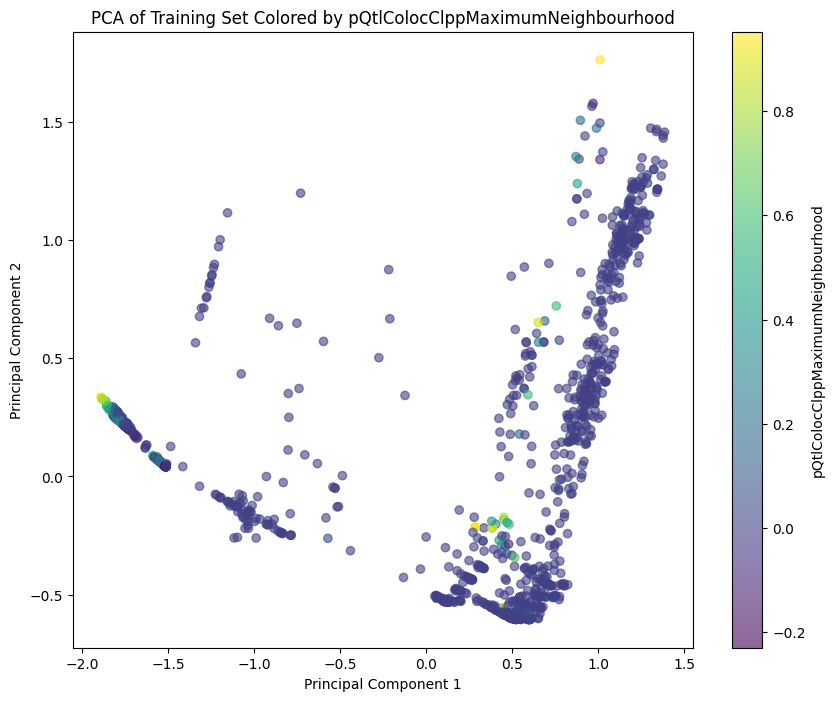

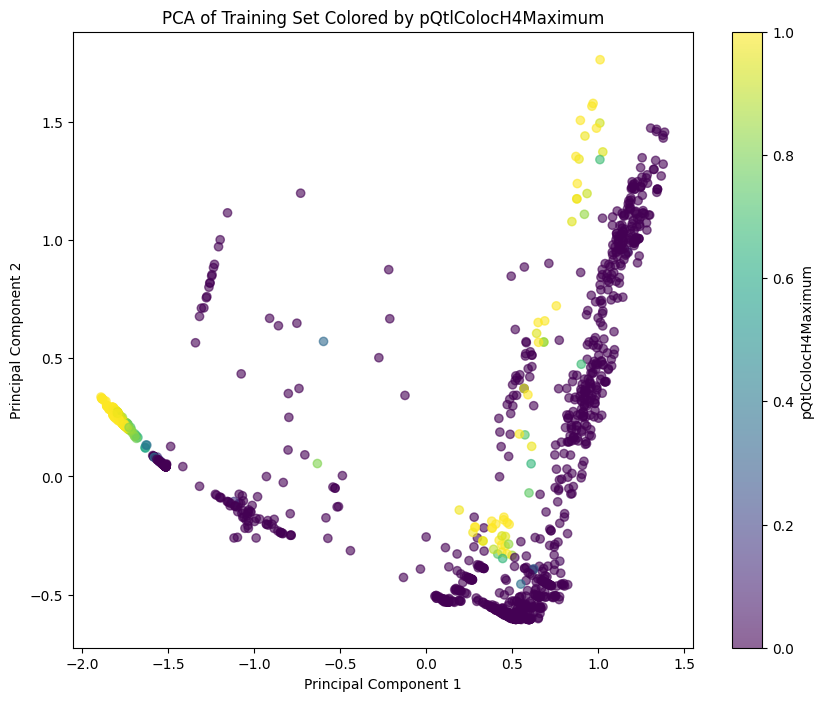

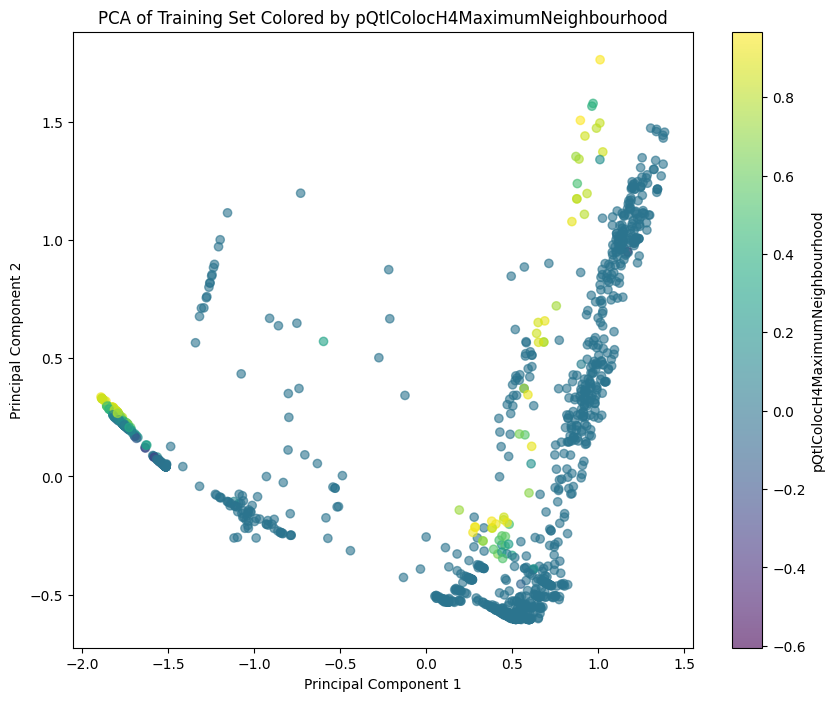

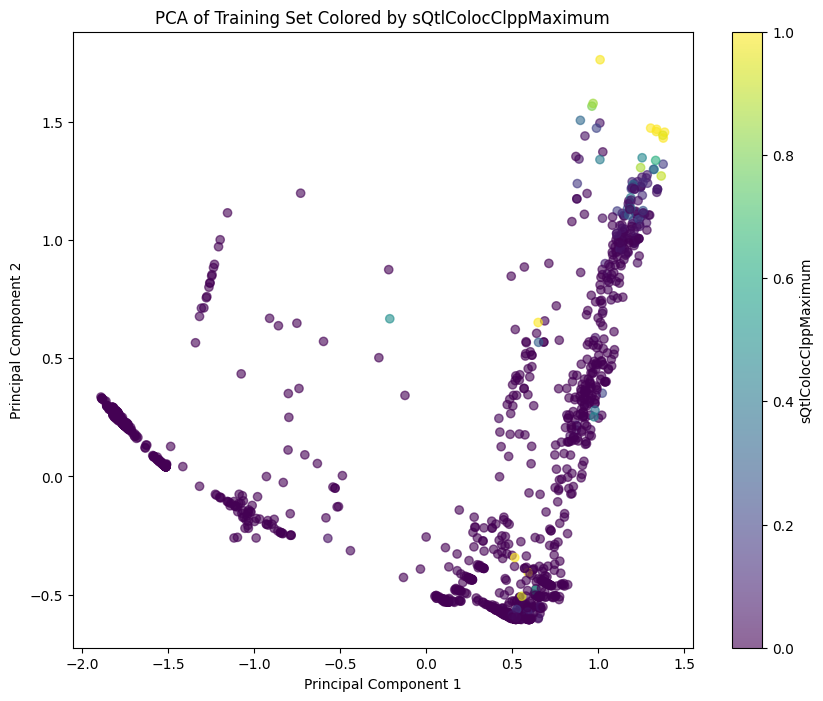

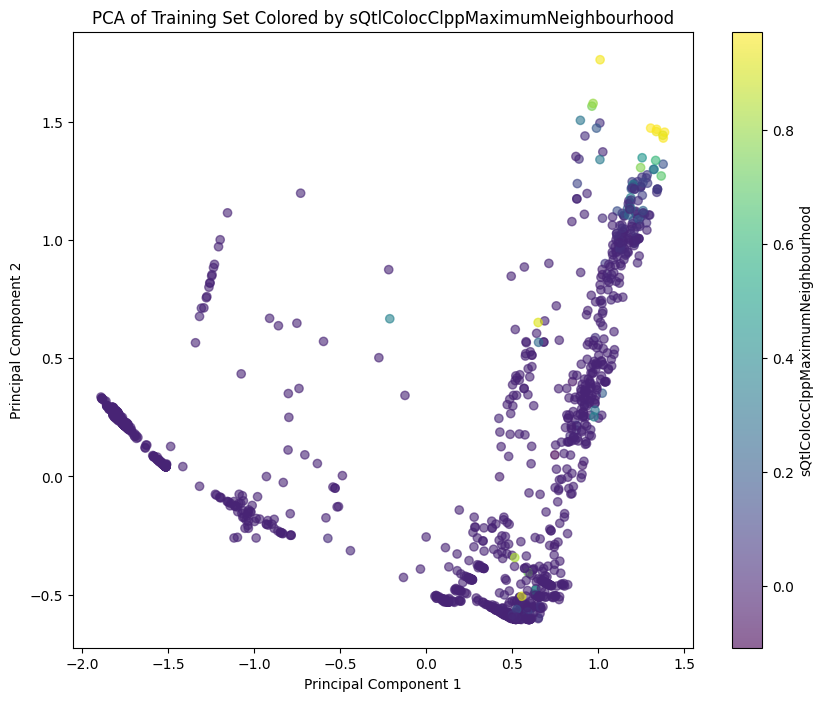

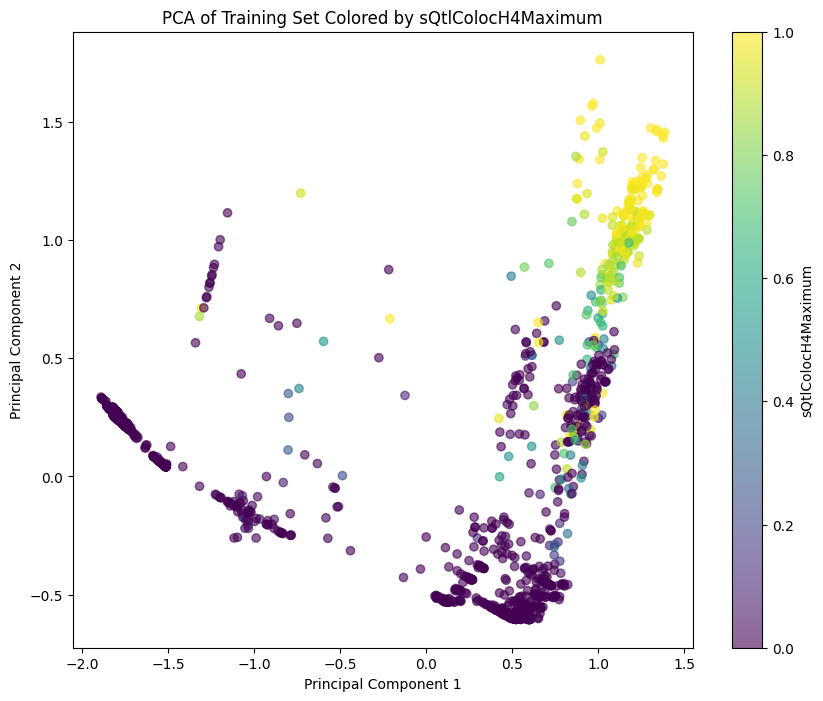

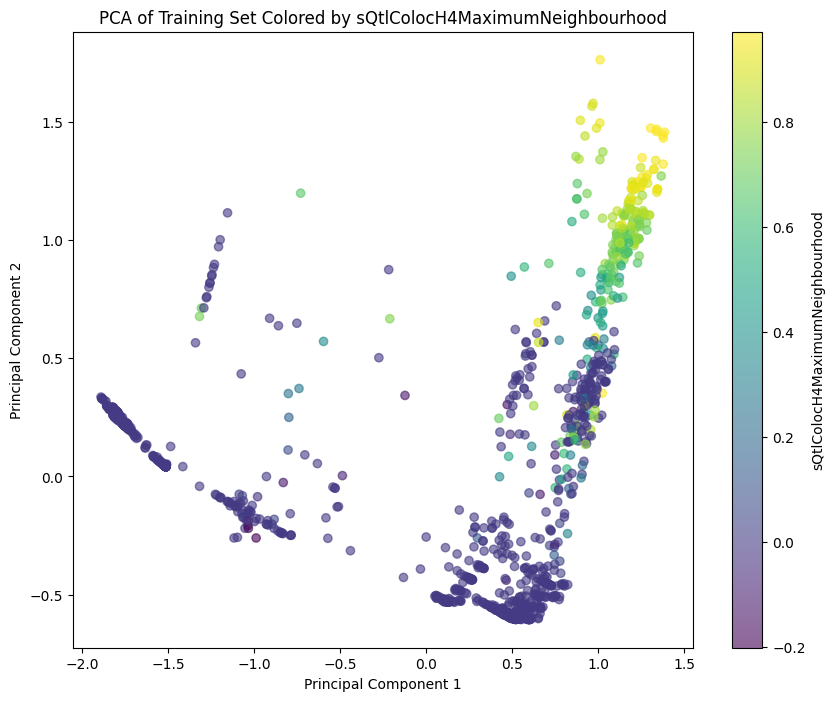

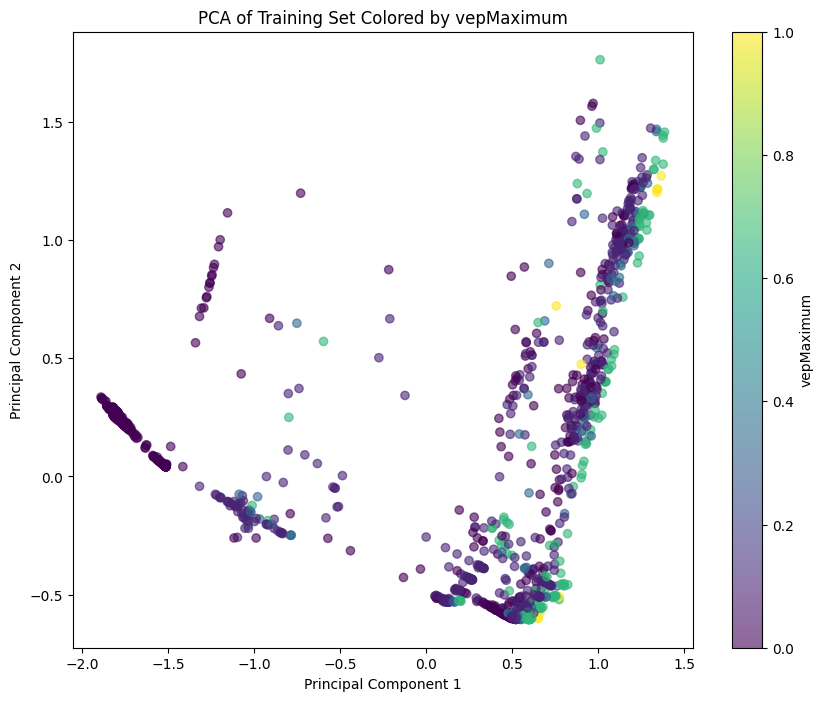

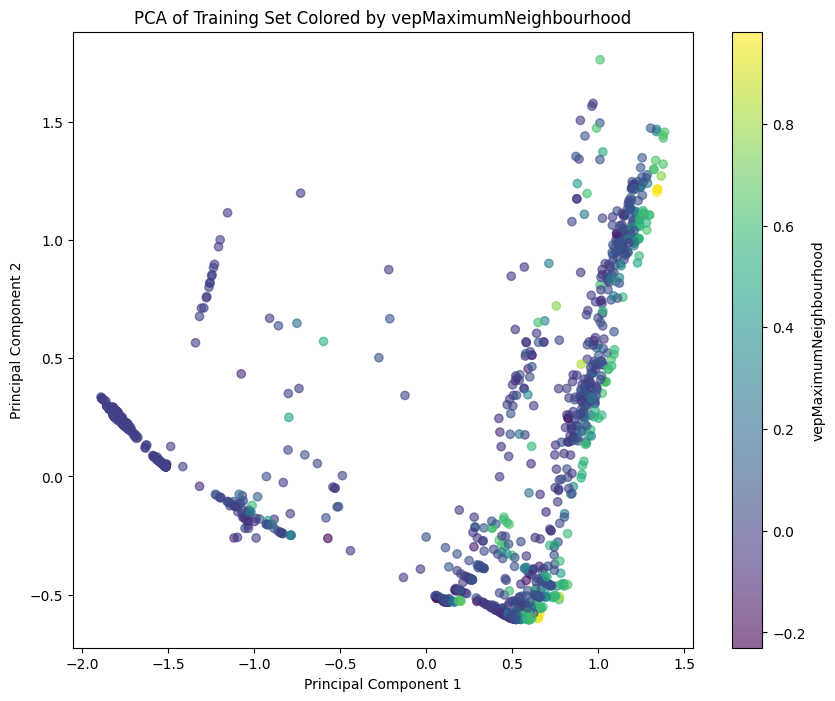

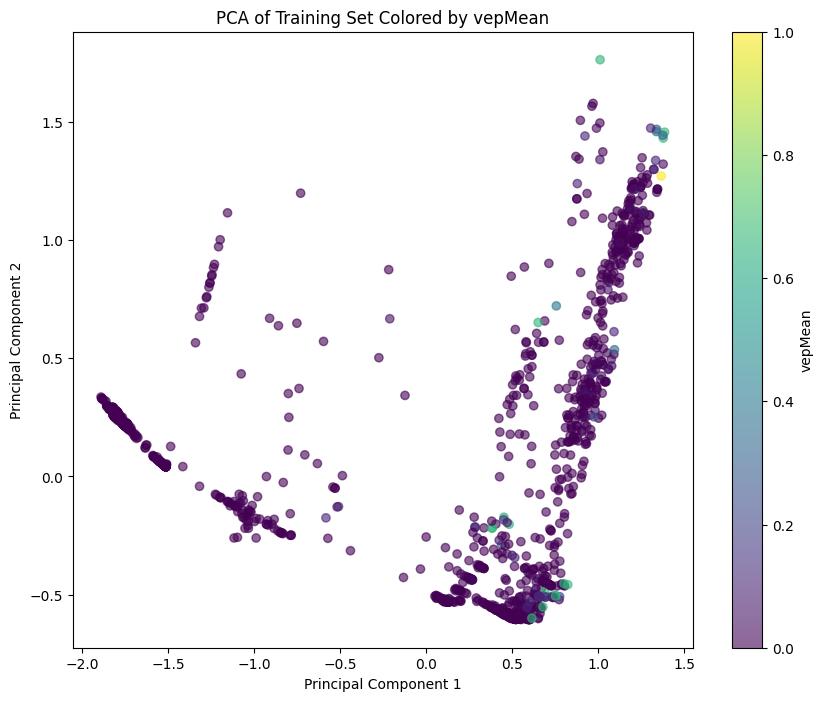

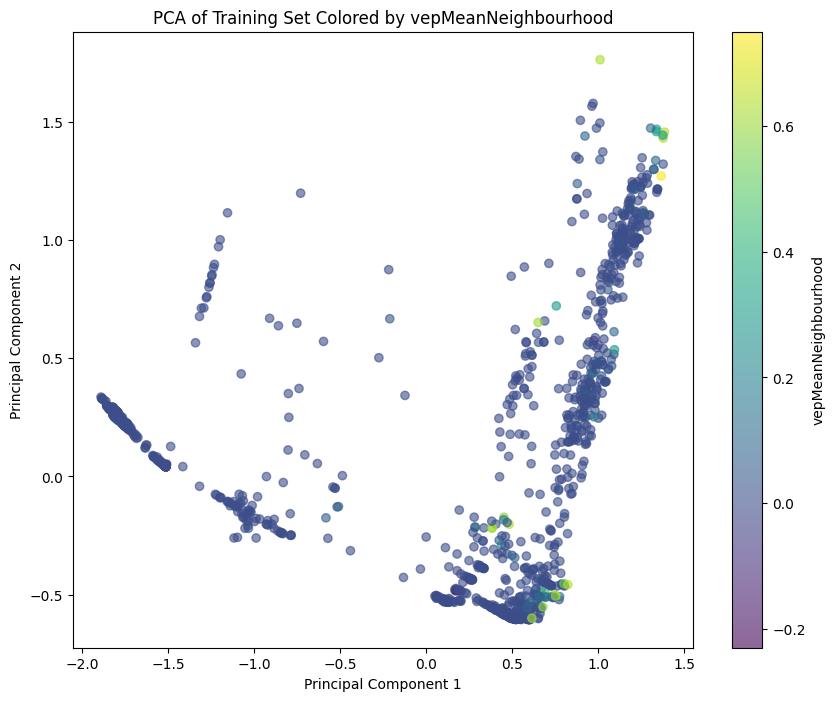

In [27]:
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

training_set_filled = training_set.fillna(0)
columns_for_pca = [col for col in training_set_filled.columns if col not in ["studyLocusId", "geneId", "Goldstandard_positive", "null_or_zero_count", "geneCount500kb", "proteinGeneCount500kb"]]

assembler = VectorAssembler(inputCols=columns_for_pca, outputCol="features", handleInvalid="keep")
df_with_features = assembler.transform(training_set_filled)
pandas_df = df_with_features.select("features", *columns_for_pca).toPandas()

features = pd.DataFrame(pandas_df["features"].apply(lambda x: x.toArray()).tolist(), columns=columns_for_pca)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)
pca_df = pd.DataFrame(data=pca_result, columns=["PC1", "PC2"])

for col in columns_for_pca:
    plt.figure(figsize=(10, 8))
    plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pandas_df[col], cmap="viridis", alpha=0.6)
    plt.colorbar(label=col)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title(f"PCA of Training Set Colored by {col}")
    plt.show()

In [22]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

n_subplots = 4
cols_per_page = 2
rows_per_page = 2

with PdfPages("pca_plots_gspn.pdf") as pdf:
    for i in range(0, len(columns_for_pca), n_subplots):
        fig, axes = plt.subplots(rows_per_page, cols_per_page, figsize=(12, 10))
        for j, col in enumerate(columns_for_pca[i:i + n_subplots]):
            row, col_idx = divmod(j, cols_per_page)
            ax = axes[row, col_idx]
            sc = ax.scatter(pca_df["PC1"], pca_df["PC2"], c=pandas_df[col], cmap="viridis", alpha=0.6)
            fig.colorbar(sc, ax=ax, label=col)
            ax.set_xlabel("Principal Component 1")
            ax.set_ylabel("Principal Component 2")
            ax.set_title(f"PCA of Training Set Colored by {col}")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)